# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Download the training, validation and test data (do this if the week1/data folder is empty)

### Text preprocessing
For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from nltk:

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anupam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval

def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

train_data = read_data('data/train.tsv') 
val_data = read_data('data/validation.tsv')   
test_data = pd.read_csv('data/test.tsv', sep='\t')
train_data.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [3]:
X_train = train_data['title'].values
y_train = train_data['tags'].values
X_val = val_data['title'].values
y_val = val_data['tags'].values
X_test = test_data['title'].values
print(X_train.shape, y_train.shape)

(100000,) (100000,)


One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_text_prepare* to test it on tiny cases and submit it to Coursera.

In [4]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    return text.strip()


In [5]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'    
    
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [6]:
# Display full text in column
pd.set_option('display.max_colwidth', None)
df_test_text = pd.read_csv('data/text_prepare_tests.tsv', '\t', names=['test_text'])
df_test_text['test_text_processed'] = df_test_text['test_text'].apply(text_prepare)
df_test_text.head(10)


,test_text,test_text_processed
0,SQLite/PHP read-only?,sqlite php readonly
1,Creating Multiple textboxes dynamically,creating multiple textboxes dynamically
2,"that, self or me — which one to prefer in JavaScript?",self one prefer javascript
3,Save PHP date string into MySQL database as timestamp,save php date string mysql database timestamp
4,How I can fill my DropDownList with Data from a XML File in my ASP.NET Application,fill dropdownlist data xml file aspnet application
5,"Programmatically trigger a jQuery-UI draggable's ""drag"" event",programmatically trigger jqueryui draggables drag event
6,How to get the value of a method argument via reflection in Java?,get value method argument via reflection java
7,Knockout maping.fromJS for observableArray from json object. Data gets lost,knockout mapingfromjs observablearray json object data gets lost
8,"Facebook Connect from Localhost, doing some weird stuff",facebook connect localhost weird stuff
9,fullcalendar prev / next click,fullcalendar prev next click


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [7]:
X_train = np.array([text_prepare(text) for text in X_train])
X_val = np.array([text_prepare(text) for text in X_val])
X_test = np.array([text_prepare(text) for text in X_test])
X_train.shape

(100000,)

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [8]:
def get_word_count(data):
    word_count = {}
    for text in data:    
        for word in text.split():
            if word in word_count.keys():
                word_count[word] += 1
            else:
                word_count[word] = 1
    return word_count

train_word_freq = get_word_count(X_train)

def get_topn_dictitems_byvalue(dict_data, n):
    freq_word = [(value, key) for key, value in dict_data.items()]
    freq_word.sort(reverse=True, key=lambda k: k[0])
    return freq_word[:n]

print('3 most popular words in train data are:')
for item in get_topn_dictitems_byvalue(train_word_freq, 3):
    print(f"'{item[1]}' with a count of {item[0]}")



3 most popular words in train data are:
'using' with a count of 8278
'php' with a count of 5614
'java' with a count of 5501


In [9]:
print(len(train_word_freq.keys()))

31497


In [10]:
def get_tag_count(tag_data):
    tag_count = {}
    for tags in tag_data:
        for tag in tags:
            if tag in tag_count.keys():
                tag_count[tag] += 1
            else:
                tag_count[tag] = 1
    return tag_count
    
tag_freq = get_tag_count(y_train)    
print('3 most popular tags in train data are:')
top3_tags = get_topn_dictitems_byvalue(tag_freq, 3)
for item in top3_tags:
    print(f"'{item[1]}' with a count of {item[0]}")                

3 most popular tags in train data are:
'javascript' with a count of 19078
'c#' with a count of 19077
'java' with a count of 18661


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [11]:
DICT_SIZE = 5000
# we use the most frequent 5000 words as our vocabulary
VOCAB = [item[1] for item in get_topn_dictitems_byvalue(train_word_freq, DICT_SIZE)]
WORDS_TO_INDEX = {word: i for i, word in enumerate(VOCAB)}

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index.keys():
            result_vector[words_to_index[word]] += 1
    return result_vector

In [12]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print(test_my_bag_of_words())   

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [13]:
from scipy.sparse import csr_matrix

X_train_compressed = csr_matrix([my_bag_of_words(text, WORDS_TO_INDEX, 5000) for text in X_train])
X_val_compressed = csr_matrix([my_bag_of_words(text, WORDS_TO_INDEX, 5000) for text in X_val])
X_test_compressed = csr_matrix([my_bag_of_words(text, WORDS_TO_INDEX, 5000) for text in X_test])

In [14]:
def get_row_nonzero_count(csr_matrix, row_index):
    row = csr_matrix[row_index].toarray()[0]    
    non_zero_items = [(i, item) for i, item in enumerate(row) if item != 0]
    return len(non_zero_items)

get_row_nonzero_count(X_train_compressed, 10)

7

Instead of custom code one case use sklearn's implementation to convert input text data to bag of words sparse matrix representation

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=VOCAB)
X_train_csr = vectorizer.transform(X_train)
print(X_train_csr.shape)
nonzero_terms = vectorizer.inverse_transform(X_train_csr[10])
print(len(nonzero_terms[0]))

(100000, 5000)
7


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf.shape


(100000, 17778)

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [17]:
if 'c++' not in tfidf_vectorizer.vocabulary_.keys():
    print('no c++ in vocabulary')
if 'c#' not in tfidf_vectorizer.vocabulary_.keys():
    print('no c# in vocabulary')    

no c++ in vocabulary
no c# in vocabulary


If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

In [18]:
tfidf_vectorizer = TfidfVectorizer(token_pattern='\S+', max_df=0.9, min_df=5, ngram_range=(1,2))
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_train_tfidf.shape

(100000, 18300)

In [19]:
if 'c++' in tfidf_vectorizer.vocabulary_.keys():
    print('c++ in vocabulary')
if 'c#' in tfidf_vectorizer.vocabulary_.keys():
    print('c# in vocabulary')    

c++ in vocabulary
c# in vocabulary


### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train)
y_val_binary = mlb.fit_transform(y_val)
print(y_train_binary.shape, y_val_binary.shape)
output_tag_labels = mlb.classes_
output_tag_labels

(100000, 100) (30000, 100)


array(['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class',
       'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date',
       'datetime', 'django', 'dom', 'eclipse', 'entity-framework',
       'excel', 'facebook', 'file', 'forms', 'function', 'generics',
       'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel',
       'linq', 'linux', 'list', 'loops', 'maven', 'mongodb',
       'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c',
       'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php',
       'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r',
       'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3',
       'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring',
       'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing',
       'twitter-bootstrap'

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

def train_classifier():
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    mnb = MultinomialNB()
    ovr = OneVsRestClassifier(mnb)    
    return ovr
    

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

If you receive a convergence warning, please set parameter *max_iter* in LogisticRegression to a larger value (the default is 100).

In [56]:
classifier_mybag = train_classifier()
classifier_mybag.fit(X_train_compressed, y_train_binary)

OneVsRestClassifier(estimator=MultinomialNB())

In [57]:
classifier_tfidf = train_classifier()
classifier_tfidf.fit(X_train_tfidf, y_train_binary)

OneVsRestClassifier(estimator=MultinomialNB())

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [58]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_compressed)
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)

In [59]:
# For predictions done using TfIdfVectorizer
y_val_pred_tfidf = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val = mlb.inverse_transform(y_val_binary)
y_val_pred_tfidf = [",".join(item) for item in y_val_pred_tfidf]
y_val = [",".join(item) for item in y_val]
df_tfidf = pd.DataFrame(list(zip(X_val, y_val, y_val_pred_tfidf)), columns=['title', 'true tags', 'predicted tags'])
df_tfidf.head(100)

,title,true tags,predicted tags
0,odbc_exec always fail,"php,sql",
1,access base classes variable within child class,javascript,
2,contenttype application json required rails,"ruby,ruby-on-rails",
3,sessions sinatra used pass variable,"ruby,session",
4,getting error type json exist postgresql rake db migrate,"json,ruby,ruby-on-rails",
...,...,...,...
95,websocket handshake secwebsocketaccept header value incorrect,"c++,javascript",
96,close opened page wpf c#,"c#,wpf,xaml",c#
97,routing issue aspnet mvc 5 get,"asp.net-mvc,c#",c#
98,thisparentelement,javascript,


In [60]:
# For predictions done using CountVectorizer
y_val_pred_mybag = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_pred_mybag = [",".join(item) for item in y_val_pred_mybag]
df_mybag = pd.DataFrame(list(zip(X_val, y_val, y_val_pred_mybag)), columns=['title', 'true tags', 'predicted tags'])
df_mybag.head(100)

,title,true tags,predicted tags
0,odbc_exec always fail,"php,sql",
1,access base classes variable within child class,javascript,class
2,contenttype application json required rails,"ruby,ruby-on-rails","json,ruby-on-rails"
3,sessions sinatra used pass variable,"ruby,session","ruby,session"
4,getting error type json exist postgresql rake db migrate,"json,ruby,ruby-on-rails",ruby-on-rails
...,...,...,...
95,websocket handshake secwebsocketaccept header value incorrect,"c++,javascript",
96,close opened page wpf c#,"c#,wpf,xaml","c#,wpf"
97,routing issue aspnet mvc 5 get,"asp.net-mvc,c#","asp.net,asp.net-mvc,c#"
98,thisparentelement,javascript,


Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [61]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def print_multilabel_classification_metrics(y_true, y_pred):
    acc_tfidf = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')    
    print(f"accuracy score = {round(acc_tfidf, 4)} \nmacro f1 score = {round(f1_macro, 4)} \nmicro f1 score = {round(f1_micro, 4)} \nweighted f1 score = {round(f1_weighted, 4)}" )

print("With tfidf")
print_multilabel_classification_metrics(y_val_binary, y_val_predicted_labels_tfidf)
print("With mybag")
print_multilabel_classification_metrics(y_val_binary, y_val_predicted_labels_mybag)


With tfidf
accuracy score = 0.1982 
macro f1 score = 0.1107 
micro f1 score = 0.4602 
weighted f1 score = 0.3981
With mybag
accuracy score = 0.283 
macro f1 score = 0.4546 
micro f1 score = 0.6307 
weighted f1 score = 0.6296


For each of the 100 output labels calculate the ROC AUC score which is the area under the ROC curve for the classifier for each of the 100 labels 

In [62]:
from sklearn.metrics import roc_auc_score
y_score_proba_mybag = classifier_mybag.predict_proba(X_val_compressed)
auc_score_mybag = roc_auc_score(y_val_binary, y_score_proba_mybag, average=None)
auc_score_mybag = sorted(auc_score_mybag, reverse=True)
print("ROC AUC score for multilabel classification using bag of words approach")
print(auc_score_mybag)

ROC AUC score for multilabel classification using bag of words approach
[0.9831588585440422, 0.980359815044841, 0.9746103312181591, 0.9722954019399508, 0.9713494476110738, 0.9713058492462096, 0.9711326851429005, 0.9697808495091602, 0.9675066264794135, 0.9672929093672087, 0.9671841462350081, 0.9671185564945821, 0.9664780238379125, 0.9662744284927685, 0.9640806747411692, 0.9628930349832774, 0.962751398617147, 0.9625316404607627, 0.959134344651668, 0.9585077525869863, 0.9568091535004748, 0.9565459185382523, 0.956271045703404, 0.9559798483617855, 0.9550247398557963, 0.9540853482029953, 0.953902858284433, 0.9538717532685909, 0.9535649550336577, 0.9525845430085029, 0.9524082394999722, 0.9518092069040769, 0.9499723091907554, 0.949227337466488, 0.9482897102588145, 0.9478216205671219, 0.9477948972919222, 0.9470235018533841, 0.9462202869426233, 0.9455616219495349, 0.9450626124296297, 0.9419923176466363, 0.9412646827838312, 0.940662455738117, 0.9404668189857095, 0.9387703498391481, 0.938389911479

In [63]:
from sklearn.metrics import roc_auc_score
y_score_proba_tfidf = classifier_tfidf.predict_proba(X_val_tfidf)
auc_score_tfidf = roc_auc_score(y_val_binary, y_score_proba_tfidf, average=None)
print("ROC AUC score for multilabel classification using tfidf approach")
print(auc_score_tfidf)

ROC AUC score for multilabel classification using tfidf approach
[0.81151127 0.88688081 0.86039135 0.90845674 0.95829751 0.81611632
 0.92946459 0.88558721 0.8375571  0.9398344  0.95006956 0.94684582
 0.80748694 0.77866982 0.9333303  0.90541552 0.88651207 0.76199757
 0.92964506 0.91780793 0.94568621 0.74538131 0.90042681 0.93874372
 0.93164101 0.93804824 0.78971465 0.85943154 0.8084479  0.91439151
 0.96774259 0.94950283 0.88858364 0.81211842 0.86248743 0.93835078
 0.91626262 0.95749933 0.96094632 0.93562731 0.9146397  0.86155027
 0.94173247 0.93401303 0.84779624 0.87228235 0.7308664  0.9294666
 0.90484786 0.91174948 0.92095971 0.91013728 0.92318744 0.9547693
 0.8045415  0.91484839 0.87073786 0.96392577 0.79696157 0.82235056
 0.96077816 0.91500093 0.96355653 0.73311642 0.78677002 0.89499523
 0.96795346 0.95836986 0.84153388 0.90977779 0.95299048 0.8222959
 0.92720931 0.84912881 0.87746109 0.92255923 0.90049348 0.94140172
 0.90846303 0.856978   0.86150649 0.90681161 0.94986985 0.90782071


{'javascript': 38, 'c#': 10, 'java': 37}


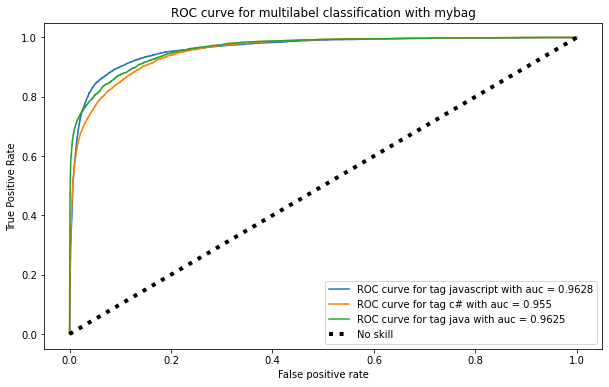

In [64]:
from sklearn import metrics
import matplotlib.pyplot as plt

# plot the roc curve
def plot_roc_curve(y_true, y_pred, label_index_dict, approach):
    plt.figure(figsize=(10, 6))
    for label, index in label_index_dict.items():          
        y = y_true[:, index]
        y_score = y_pred[:, index]      
        auc_score = roc_auc_score(y, y_score)
        fpr, tpr, thresholds = metrics.roc_curve(y, y_score)        
        plt.plot(fpr, tpr, label=f"ROC curve for tag {label} with auc = {round(auc_score, 4)}")
    plt.plot([0,1], [0,1], linestyle=":", linewidth=4, color="black", label="No skill")        
    plt.title(f'ROC curve for multilabel classification with {approach}')
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

label_index_dict = {}
for count, tag in top3_tags:
    for i, label in enumerate(output_tag_labels):
        if label == tag:
            label_index_dict[label] = i

print(label_index_dict)
plot_roc_curve(y_val_binary, y_score_proba_mybag, label_index_dict, "mybag")


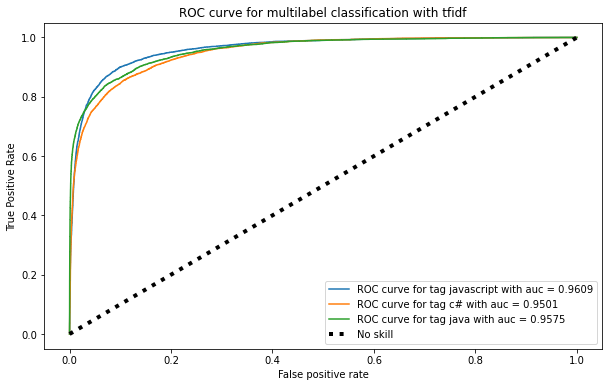

In [65]:
plot_roc_curve(y_val_binary, y_score_proba_tfidf, label_index_dict, "tfidf")

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [66]:

mybag_test_preds = classifier_mybag.predict(X_test_compressed)
mybag_test_pred_tags = mlb.inverse_transform(mybag_test_preds)
mybag_test_pred_tags = [",".join(item) for item in mybag_test_pred_tags]
df_mybag_test_pred = pd.DataFrame(list(zip(X_test, mybag_test_pred_tags)), columns=['title', 'predicted tags'])
df_mybag_test_pred.head(20)

,title,predicted tags
0,warning mysql_query expects parameter 2 resource object given,"mysql,php"
1,get click coordinates input typeimage via javascript,"html,javascript,jquery"
2,implement cloud storage media assets zf,android
3,catcomplete jquerys autocomplete plugin,"javascript,jquery"
4,error building android app cordova 31 cli,"android,java"
5,parse xml file php,"php,xml"
6,uploading files via json post request web service provided teambox,"ajax,json,php,web-services"
7,adding rows jtable right order,java
8,read input file python,python
9,pdf generation html containing images text,html


In [67]:
# predictions on test set with features created using tfidf
tfidf_test_preds = classifier_tfidf.predict(X_test_tfidf)
tfidf_test_pred_tags = mlb.inverse_transform(tfidf_test_preds)
tfidf_test_pred_tags = [",".join(item) for item in tfidf_test_pred_tags]
df_tfidf_test_pred = pd.DataFrame(list(zip(X_test, tfidf_test_pred_tags)), columns=['title', 'predicted tags'])
df_tfidf_test_pred.head(20)

,title,predicted tags
0,warning mysql_query expects parameter 2 resource object given,php
1,get click coordinates input typeimage via javascript,javascript
2,implement cloud storage media assets zf,
3,catcomplete jquerys autocomplete plugin,"javascript,jquery"
4,error building android app cordova 31 cli,
5,parse xml file php,"php,xml"
6,uploading files via json post request web service provided teambox,
7,adding rows jtable right order,java
8,read input file python,python
9,pdf generation html containing images text,
